## POOL mAAPL_UST
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import pandas as pd

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [3]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [4]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [5]:
EXPERIMENT_ID = 66

X_NAME = 'mAAPL'
Y_NAME = 'UST'

WINDOW_SIZE = 24 * 60 * 60

In [6]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [7]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [8]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [9]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [10]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mAAPL,297.072343,0.0,2.387651,1.188289,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,542,2020-12-03 17:54:47,2020-12-03 17:54:40,0x5c450e4f9908aa58814be20fc50d60b03c3798f99af7...,1,2532.620000,311664.217000,7.893270e+08,0,0,False,2530.232349,311960.101054,7.893315e+08,0,0,False,123.293065,0.001894
1,3,UST,mAAPL,1000.000000,0.0,8.004252,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,907,2020-12-03 19:26:02,2020-12-03 19:25:57,0x5cc783f79cdab6a966cc9de5d69215dd4199c1f367af...,3,2530.732349,312021.748232,7.896435e+08,0,0,False,2522.728096,313017.748232,7.896587e+08,675029,44,False,124.079067,0.006375
2,5,UST,mAAPL,1000.000000,0.0,7.953707,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1004,2020-12-03 19:50:17,2020-12-03 19:50:13,0x0d5279feeb6c1536f2f8ee5efda3901352e6697fb84a...,5,2530.788680,314017.943510,7.947131e+08,675029,44,False,2522.834973,315013.943510,7.947282e+08,855564,56,False,124.865061,0.006334
3,6,UST,mAAPL,10000.000000,0.0,76.869789,40.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1008,2020-12-03 19:51:17,2020-12-03 19:51:07,0x339975916e81727fbf0060810da871921ca5aecb85aa...,6,2522.834973,315013.943510,7.947282e+08,855564,56,False,2445.965184,324973.943510,7.948750e+08,863056,56,False,132.861230,0.064038
4,7,UST,mAAPL,5000.000000,0.0,36.697936,20.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1013,2020-12-03 19:52:32,2020-12-03 19:52:27,0xd2ad1e3793ea315c70b1bd90999caffbe498eb5aefab...,7,2445.965184,324973.943510,7.948750e+08,863056,56,False,2409.267249,329953.943510,7.949472e+08,873021,57,False,136.951990,0.030790


In [11]:
swaps0_df.status.value_counts()

SUCCESS    2117
Name: status, dtype: int64

In [12]:
swaps1_df.status.value_counts()

SUCCESS    2117
Name: status, dtype: int64

In [13]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [14]:
swaps1_df.mitigator_check_status.value_counts()

CANT_CONSULT_ORACLE    1640
CHECKED                 477
Name: mitigator_check_status, dtype: int64

In [15]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.7746811525743977


In [16]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    273
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    273
Name: status, dtype: int64


**0** have been **blocked by the volatility mitigation mechanism**. In about **77%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

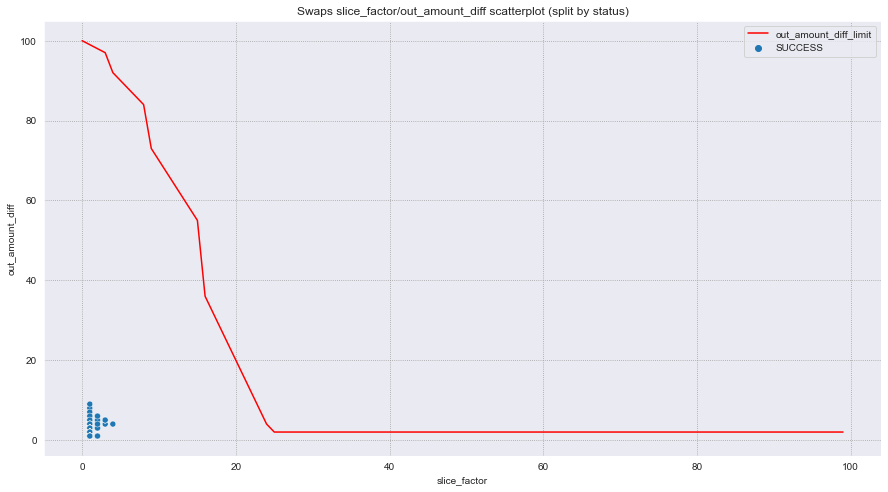

In [17]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be observed that for all swaps checked by the volatility mitigation mechanism the slice_factor is pretty small, which is caused by the high pool reserves. The limit until which a transaction would be blocked is pretty big**

Text(0, 0.5, 'Count')

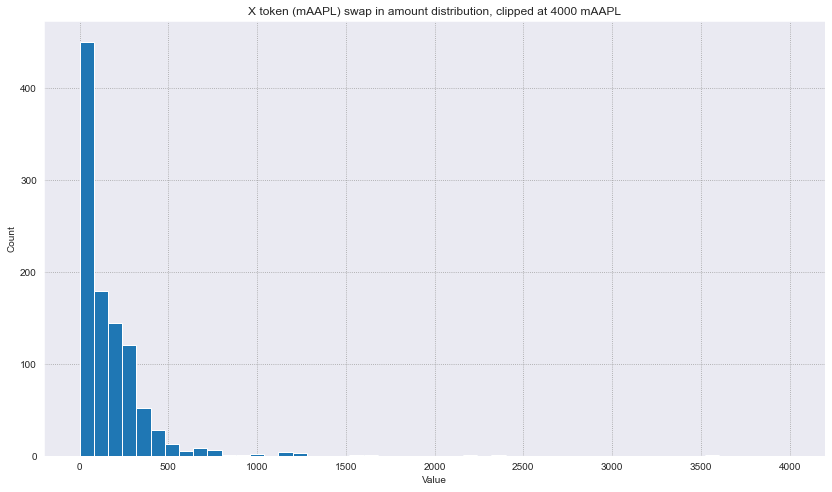

In [18]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

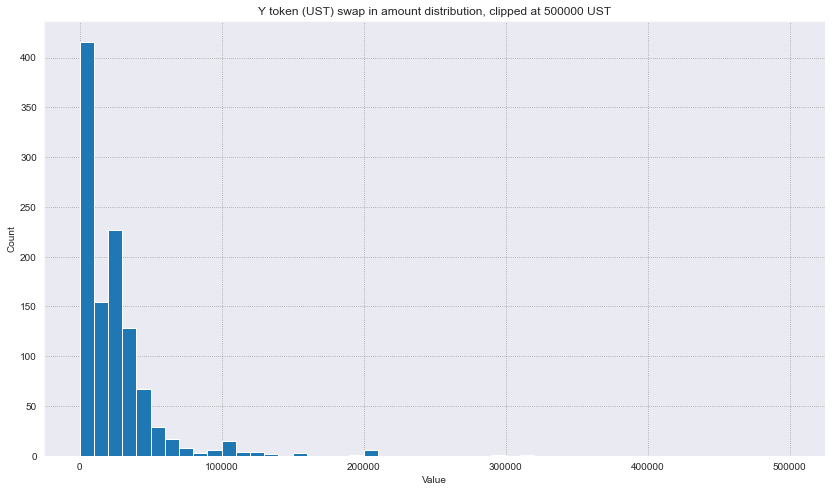

In [19]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

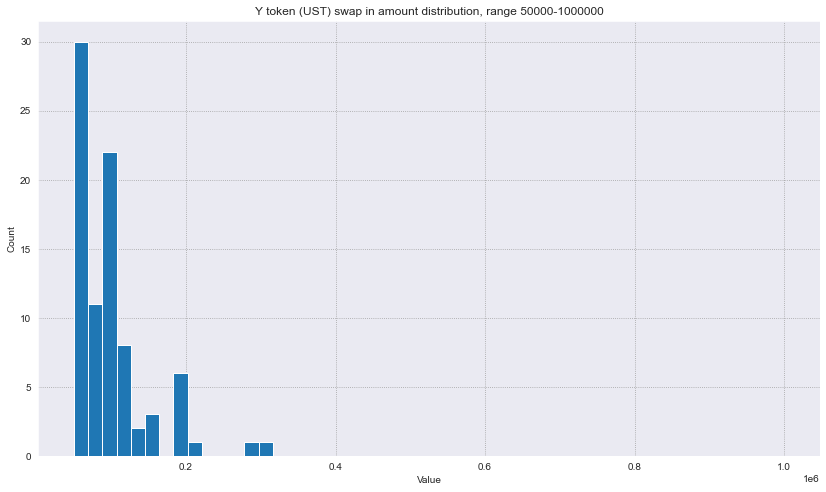

In [20]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

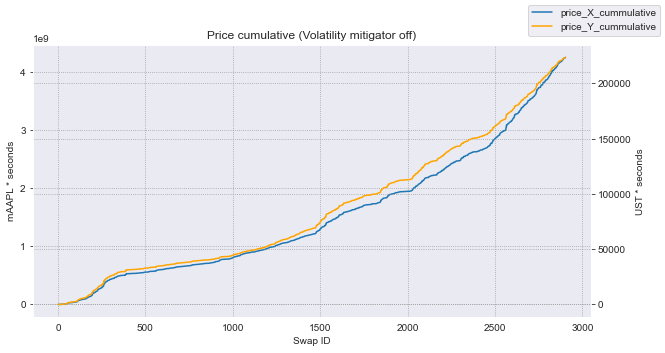

In [21]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

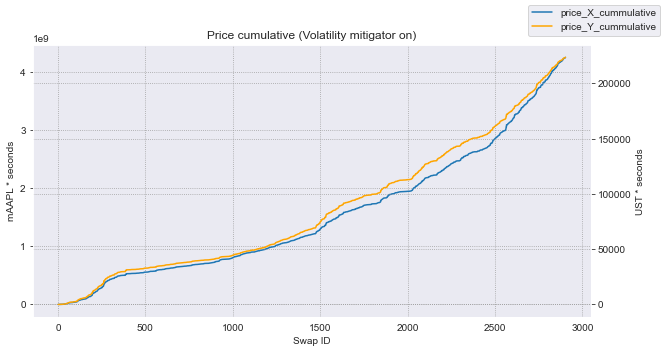

In [22]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

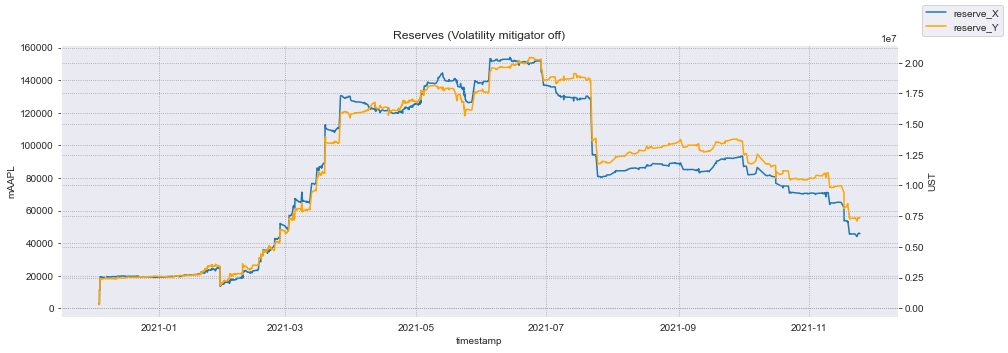

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

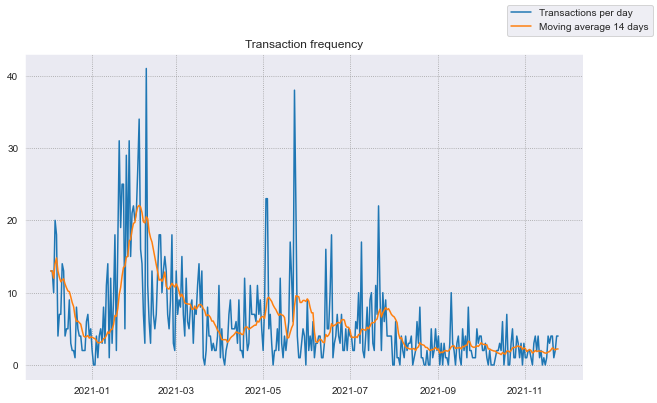

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('24h').size()
mov_avg = resampled.rolling('14d').mean()

plt.plot_date(resampled.index, resampled.values, markersize=1, linestyle='solid', marker='None', label='Transactions per day')
plt.plot_date(mov_avg.index, mov_avg.values, markersize=1, linestyle='solid', marker='None', label='Moving average 14 days')

ax.set_title('Transaction frequency')
fig.legend()

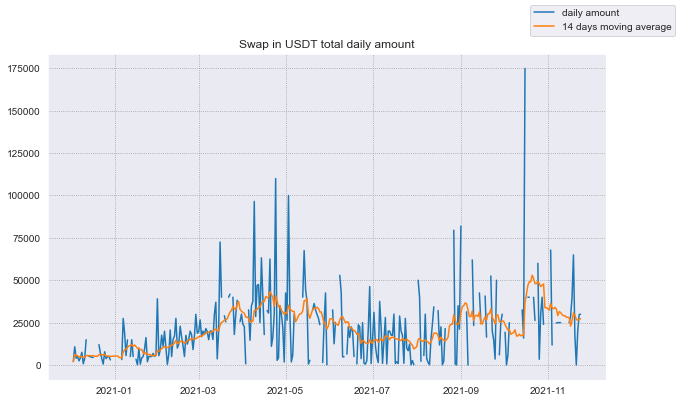

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

sim1_indexed_df = swaps1_df[swaps1_df.token_in == Y_NAME].copy()
sim1_indexed_df.index = sim1_indexed_df.transaction_timestamp
resampled = sim1_indexed_df.resample('24h').median().token_in_amount
mov_avg = resampled.rolling('14d').mean()

plt.plot_date(resampled.index, resampled.values, markersize=1, linestyle='solid', marker='None', label='daily amount')
plt.plot_date(mov_avg.index, mov_avg.values, markersize=1, linestyle='solid', marker='None', label='14 days moving average')

ax.set_title('Swap in USDT total daily amount')
fig.legend()

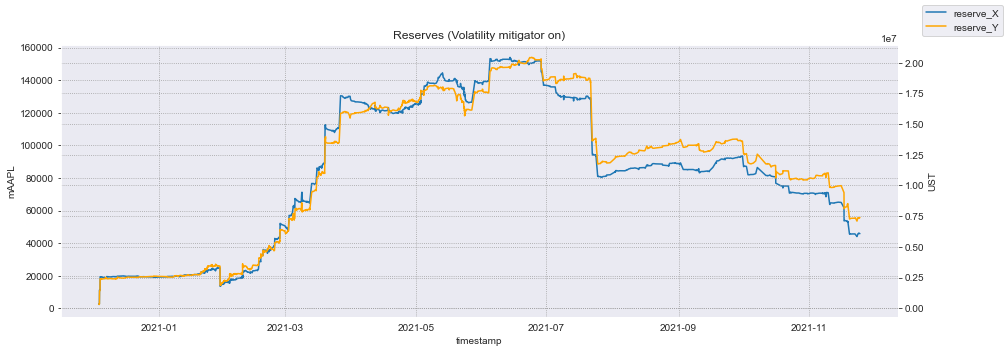

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**As no transactions have been blocked, the variation of reserves over time with and without the volatility mitigation mechanism is the same**

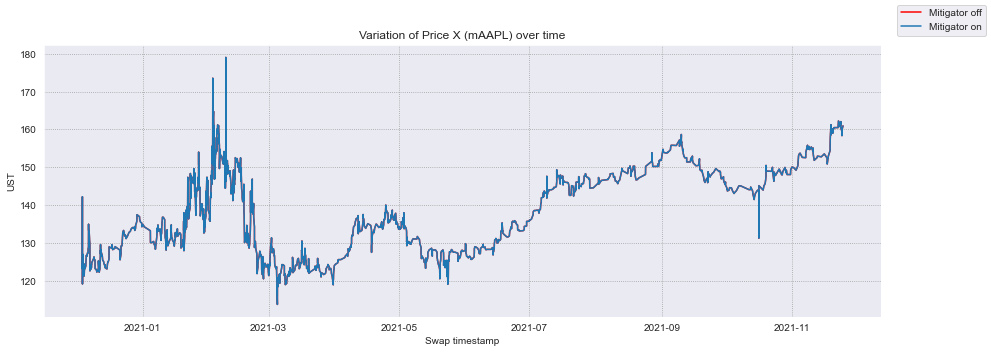

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is also the same**

## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [30]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2020-12-03 17:00:00    1
2020-12-03 18:00:00    0
2020-12-03 19:00:00    5
2020-12-03 20:00:00    3
2020-12-03 21:00:00    2
                      ..
2021-11-24 14:00:00    0
2021-11-24 15:00:00    0
2021-11-24 16:00:00    0
2021-11-24 17:00:00    0
2021-11-24 18:00:00    1
Freq: H, Length: 8546, dtype: int64

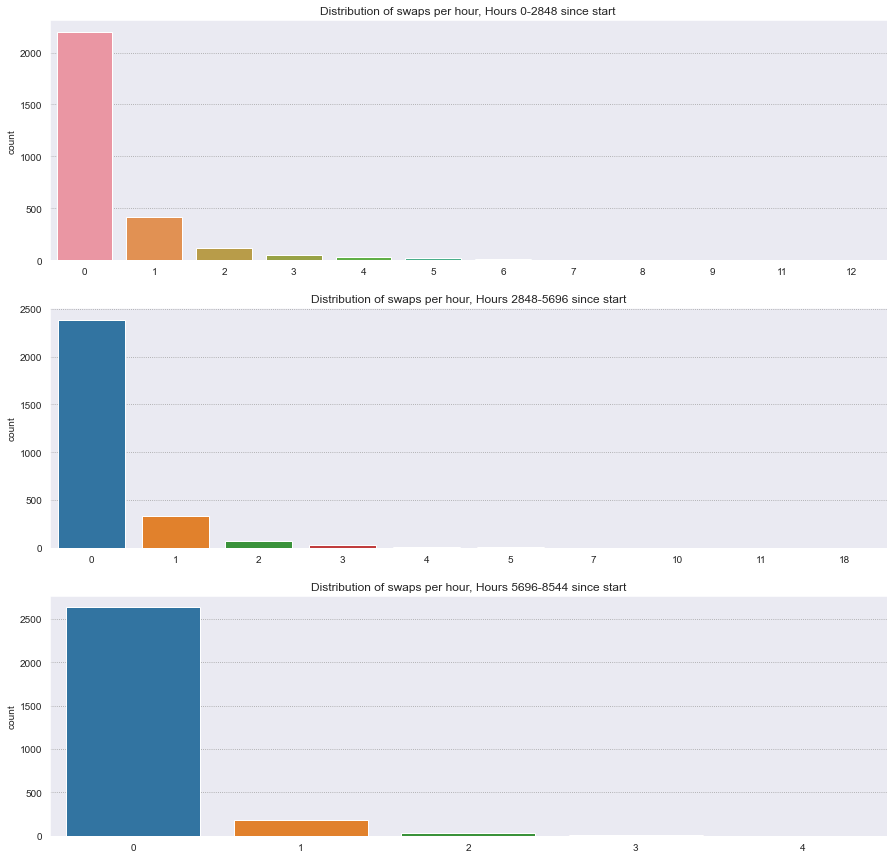

In [116]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
   # time_elapsed = (resampled.index[end_idx] - resampled.index[start_idx])
    
    sns.countplot(x=resampled.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per hour, Hours {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

**The count for x = 0 (no swaps per hour), shows how many missing periods for TWAP value exist. It can be seen that this number increases over time**

## Count number of 24 hour periods with no swaps

In [122]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled48 = sim1_indexed_df.resample('48h').size()
resampled48.head()

transaction_timestamp
2020-12-03    26
2020-12-05    30
2020-12-07    22
2020-12-09    14
2020-12-11    27
Freq: 48H, dtype: int64

In [123]:
resampled48[resampled48 == 0].shape

(4,)

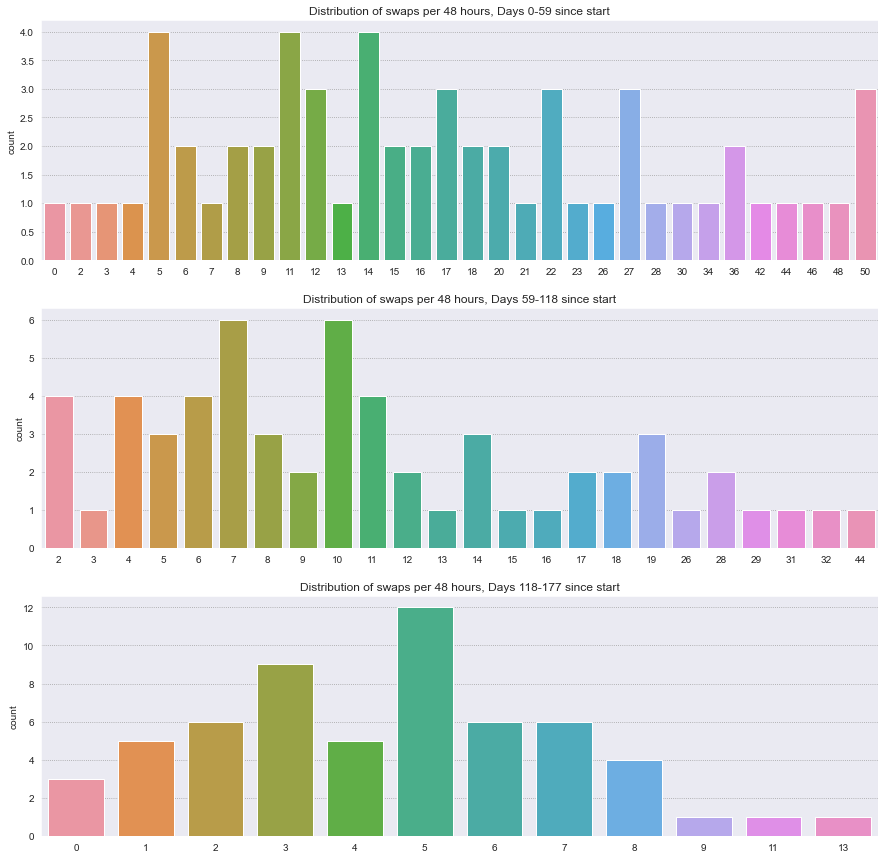

In [124]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled48)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    
    sns.countplot(x=resampled24.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per 48 hours, Days {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

**It can be seen that in the second stage the minimum number of swaps in 48 hours is 2, and in the last case, there are only 3 48-hour windows with no swaps happening**

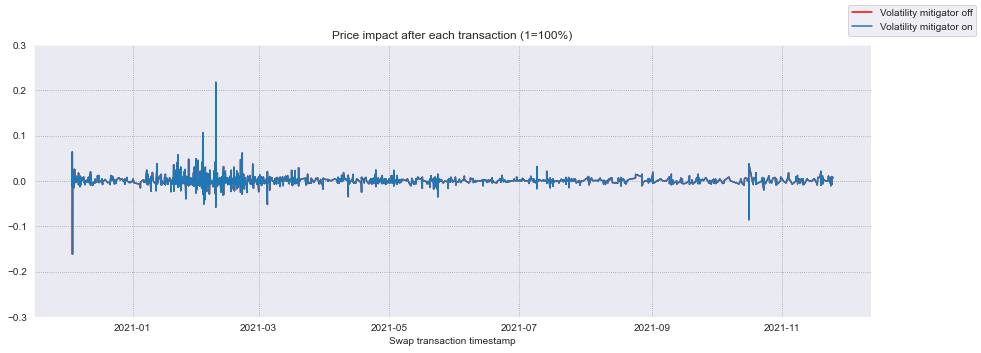

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact after each transaction doesn't exceed 0.25**

In [34]:
swaps1_df[swaps1_df.price_diff > 0.2]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
725,966,UST,mAAPL,313490.743725,0.0,1913.34116,1253.962975,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387653,2021-02-08 22:52:32,2021-02-08 22:52:22,0x7e262e31704c6c8b638fe545594ddfd7acd95ffbf2b0...,966,20457.340891,3.007952e+06,6.153470e+10,780816423,43351,True,18543.999731,3.320189e+06,6.156958e+10,780820834,43351,True,179.043837,0.217693


In [37]:
swaps1_df[swaps1_df.price_diff < -0.06]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
10,22,mAAPL,UST,241.000000,0.0,31088.346204,124.353385,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1481,2020-12-03 21:49:32,2020-12-03 21:49:24,0xb0ca987c229ecc9bfb0246ec6ab5f73755104ab6091b...,22,2600.183217,3.698930e+05,9.617895e+08,1468449,87,True,2841.183217,3.386803e+05,9.622527e+08,1867479,106,True,119.203954,-0.162049
2029,2757,mAAPL,UST,3553.094634,0.0,483217.805281,1932.871221,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1824454,2021-10-16 09:32:47,2021-10-16 09:32:45,0xe48baf0f3f5f7ff76f94a9356ec88b3df0a8c0d437f7...,2757,77217.750251,1.109084e+07,8.564098e+11,3741137091,201063,True,80770.844886,1.060569e+07,8.566306e+11,3741774811,201094,True,131.305929,-0.085809


**The transaction which cause the highest price impact wasn't checked by the volatility mitigation mechanism due to no priceCummulative observations available. It can be observed, that after this transaction, in the next 10 minutes followed 10 other swaps in another direction, which returned the price of the security token to the initial value, stabilizing the price**

In [130]:
swaps1_df.iloc[725:740]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
725,966,UST,mAAPL,313490.743725,0.0,1913.341160,1253.962975,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387653,2021-02-08 22:52:32,2021-02-08 22:52:22,0x7e262e31704c6c8b638fe545594ddfd7acd95ffbf2b0...,966,20457.340891,3.007952e+06,6.153470e+10,780816423,43351,True,18543.999731,3.320189e+06,6.156958e+10,780820834,43351,True,179.043837,0.217693
726,968,mAAPL,UST,251.381561,0.0,44042.391614,176.169566,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387655,2021-02-08 22:53:02,2021-02-08 22:52:53,0x9c25fdc9ad84bcef3527d31503aa90c89aec804f773a...,968,20462.871786,3.665379e+06,7.500418e+10,780820834,43351,True,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,174.814903,-0.024053
727,969,mAAPL,UST,61.940243,0.0,10688.156395,42.752626,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x19e9d0ab55b282ade13aa05b1e5409a2131a4f8b6bb6...,969,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,173.777225,-0.005936
728,970,mAAPL,UST,257.410694,0.0,43748.188540,174.992754,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x29d894eb37a6220a854ee2a26d0b68327bef72b34a42...,970,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,169.562289,-0.024255
729,971,mAAPL,UST,641.926100,0.0,104597.692025,418.390768,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387663,2021-02-08 22:55:02,2021-02-08 22:54:58,0xe8e506485374eb3d5324346704e27034f92168c9c0cf...,971,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,159.695747,-0.058188
730,972,mAAPL,UST,327.569478,0.0,51024.939180,204.099757,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387664,2021-02-08 22:55:17,2021-02-08 22:55:10,0xc506a51a6f701ff5860f81255471b67138510158b8fc...,972,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,154.990024,-0.029467
731,973,mAAPL,UST,336.190574,0.0,50816.450950,203.265804,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387667,2021-02-08 22:56:02,2021-02-08 22:55:57,0x2954589a88559944ca9ee734993f3ffbc32a863289bc...,973,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,150.373677,-0.029785
732,974,mAAPL,UST,66.659662,0.0,9894.390649,39.577563,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387670,2021-02-08 22:56:47,2021-02-08 22:56:35,0x3c227703596b09e360ad17457b5c13f5d9e13053a831...,974,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,149.482940,-0.005923
733,975,mAAPL,UST,68.924194,0.0,10168.992621,40.675970,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387681,2021-02-08 22:59:32,2021-02-08 22:59:32,0xd6d271f001b476b4e004bce7fb3a06514db9f84be74f...,975,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,148.570247,-0.006106
734,976,mAAPL,UST,103.565029,0.0,15163.639226,60.654557,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,387685,2021-02-08 23:00:32,2021-02-08 23:00:21,0x8e8f63e463cda0b38a57ffa91391f987d9cdc9100a36...,976,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,22578.439321,3.323873e+06,7.504787e+10,780896743,43354,True,147.214485,-0.009125


**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**